# Problem


---


Find a data set involving an interesting sequence of symbols: perhaps text, color sequences in images, or event logs from some device. Use word2vec to construct symbol embeddings from them, and explore through nearest neighbor analysis.What interesting structures do the embeddings capture?


---



The following datasets & Notebooks are refered here 

[Spy spark stress detection](https://www.kaggle.com/code/sawsanshakir/stress-detection-using-pyspark/notebook
)

[Word to vector](https://www.kaggle.com/code/cempek/bbc-nltk-clustering-word2vec-vs-tfidfvectorizer/notebook)


[Stress dataset ](https://www.kaggle.com/code/sawsanshakir/stress-detection-using-pyspark/input)

[Notebook](https://www.kaggle.com/code/sawsanshakir/stress-detection-using-pyspark/notebook
)

[word2vec](https://www.kaggle.com/code/harshitmakkar/nlp-word2vec)


---



This uses s the social media data reflecting stress . This is an extract of mental health problems shared by usrs


---



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('drive/My Drive/bbc-project/task1data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


drive/My Drive/bbc-project/task1data/sample.csv
drive/My Drive/bbc-project/task1data/test.csv
drive/My Drive/bbc-project/task1data/train.csv


In [4]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 17.4 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=07dc05a7cd348f9dd75555cec861b8a8215d64c48cbd4dcd804d6022037069bf
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [5]:
from pyspark.sql.types import StructType,StructField,DoubleType
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [6]:
# Load data through Speaksql
from pyspark.sql import SQLContext
from pyspark import SparkContext
sc =SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
data = sqlContext.read.format('com.databricks.spark.csv').option("escape", "\"").options(header='true', inferschema='true').load('drive/My Drive/bbc-project/task1data/train.csv')

/usr/local/lib/python3.9/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [7]:
data.show()

+--------+----------------+--------+--------------+--------------------+-----+-----+-----------+----------------+------------+------------+-----------+-----------------+--------------+------------------+-------------+------------+---------------+------------+-----------------+----------------+--------------+----------+-----------+------------+--------------+-------------+--------------+----------------+-------------+----------------+---------------+-------------+---------------+-------------+------------+----------------+-----------------+---------------+--------------+---------------+---------------+---------------+------------+--------------+------------+---------------+---------------+---------------+---------------+-------------+----------------+----------------+--------------+----------------+---------------+----------------+---------------+----------------+------------+-------------+-------------+------------+-------------+---------------+---------------+---------------+---------

In [8]:
# Feature Extraction 
col_list = ['subreddit', 'text']
data = data.select([column for column in data.columns if column in col_list])

In [9]:
data.show(10)

+----------------+--------------------+
|       subreddit|                text|
+----------------+--------------------+
|          stress|Hello, You are in...|
|        homeless|I want to know ab...|
|            ptsd|Have any of you r...|
|            ptsd|Whenever I have a...|
|   relationships|Throwaway because...|
|   relationships|But I really do e...|
|survivorsofabuse|We are 21 now, bo...|
|domesticviolence|I have started wo...|
|   relationships|  ---   **tl;dr**...|
|         anxiety|I just feel so na...|
+----------------+--------------------+
only showing top 10 rows



In [10]:
df_sentiments = data.toPandas()

In [11]:
df_sentiments.head()

,subreddit,text
0,stress,"Hello, You are invited to complete a survey fo..."
1,homeless,"I want to know about your story, how you got t..."
2,ptsd,Have any of you requested accommodations throu...
3,ptsd,"Whenever I have a reaction or meltdown, he alw..."
4,relationships,Throwaway because this is an embarrassing issu...


In [12]:
# All categories 
category_counts = df_sentiments.subreddit.value_counts()
categories = category_counts.index
print(categories)

Index(['ptsd', 'relationships', 'anxiety', 'domesticviolence', 'assistance',
       'survivorsofabuse', 'homeless', 'almosthomeless', 'stress',
       'food_pantry'],
      dtype='object')


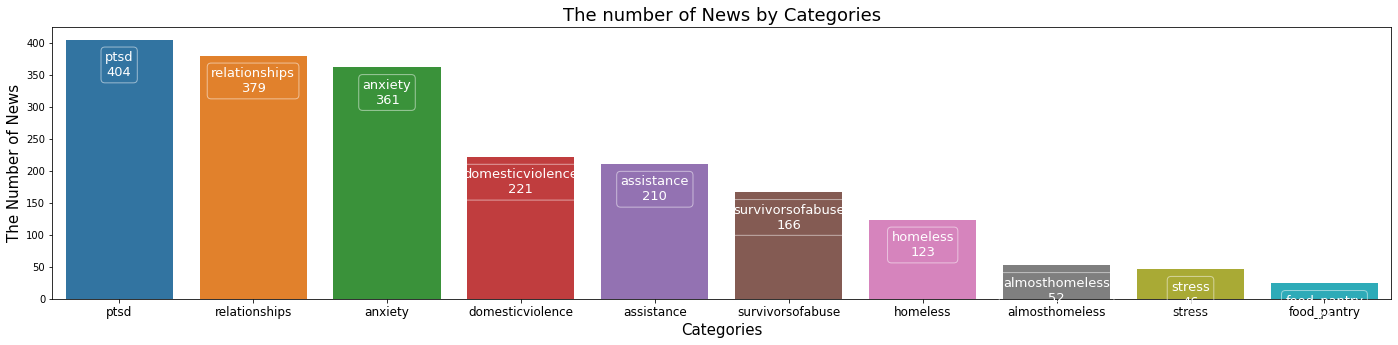

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize = (24,5))
ax = fig.add_subplot(111)
sns.barplot(x = category_counts.index , y = category_counts)
for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
plt.xlabel('Categories', size = 15)
plt.ylabel('The Number of News', size= 15)
plt.xticks(size = 12)

plt.title("The number of News by Categories" , size = 18)
plt.show()

In [ ]:
# Text Preprocessing

In [14]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
# Stemming Libraries
from nltk.stem import WordNetLemmatizer
lm = WordNetLemmatizer()
from nltk.stem.porter import PorterStemmer
pm = PorterStemmer()
from nltk.probability import FreqDist
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [15]:
import numpy as np
data = np.asarray(df_sentiments)
no_cluster = len(categories)
temp_text = []
cleaned_texts = []

for i in range(len(data)):
    temp_text.append([])
    temp_text[i] = re.sub('[^a-zA-Z]', ' ', data[i][1] )                                                                      # Remove all punctuations
    temp_text[i] = temp_text[i].lower()
    temp_text[i] = temp_text[i].split()
    temp_text[i] = [word for word in temp_text[i] if not word in set(stopwords.words('english')) ]                         # we didn't use stemming method, just get rid of stopwords
    cleaned_texts.append(temp_text[i])

### clustering  & Vectorizing the Words by Word2Vec

In [20]:
# Vectorize all words

from nltk.cluster import KMeansClusterer

def word_sentinizer(txt, model):
    text_vect = []
    no_words = 0
    for word in txt:
        if no_words ==  0:
            text_vect = model.wv[word]
        else:
            text_vect = np.add(text_vect, model.wv[word])
        no_words += 1
    return np.asarray(text_vect) / no_words

# Vectorizing withot cleaning
X = []
model = Word2Vec(cleaned_texts, min_count = 1)
for text in cleaned_texts:
    X.append(word_sentinizer(text, model))
    

In [21]:
#
#    stress = 0
#    depresson = 0
#    homeless =0
#    relationships = 0
#    anxiety = 0

#
print('*********Stress similar words**********************')
sims = model.wv.most_similar('stress', topn=10)  # get other similar words
for item in sims:
  print (item)
print('*********depression similar words**********************')
sims = model.wv.most_similar('depression', topn=10)  # get other similar words
for item in sims:
  print (item)
print('*********homeless similar words**********************')
sims = model.wv.most_similar('homeless', topn=10)  # get other similar words
for item in sims:
  print (item)
print('*********relationships similar words**********************')
sims = model.wv.most_similar('relationships', topn=10)  # get other similar words
for item in sims:
  print (item)
print('*********anxiety similar words**********************')
sims = model.wv.most_similar('anxiety', topn=10)  # get other similar words
for item in sims:
  print (item)

*********Stress similar words**********************
('would', 0.9995561838150024)
('good', 0.9995452165603638)
('going', 0.9995434284210205)
('put', 0.9995381832122803)
('us', 0.9995375275611877)
('without', 0.9995324611663818)
('said', 0.999530017375946)
('still', 0.9995274543762207)
('things', 0.9995267391204834)
('know', 0.9995238780975342)
*********depression similar words**********************
('ptsd', 0.9998008608818054)
('think', 0.9997885823249817)
('told', 0.9997861981391907)
('well', 0.9997860789299011)
('another', 0.9997854828834534)
('made', 0.9997848868370056)
('around', 0.9997843503952026)
('anxiety', 0.9997804164886475)
('love', 0.9997774362564087)
('one', 0.9997751712799072)
*********homeless similar words**********************
('us', 0.9998309016227722)
('still', 0.9998294115066528)
('one', 0.9998227953910828)
('could', 0.9998221397399902)
('also', 0.999821126461029)
('without', 0.9998207688331604)
('getting', 0.9998180270195007)
('around', 0.9998151659965515)
('little

### Cluster Documents Using (Mini-batches) K-means
####  Use the Mini-batches K-means algorithm. This K-means variant uses random input data samples to reduce the time required during training. 
#### The upside is that it shares the same objective function with the original algorithm, so, in practice, the results are just a bit worse than K-means.
[Reference](https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/)

In [22]:
# Clustering vectorized words
kclusterer = KMeansClusterer(no_cluster, distance= nltk.cluster.util.cosine_distance, repeats = 100)

assigned_clusterers = kclusterer.cluster(X, assign_clusters = True)

print(kclusterer.means())


[array([-0.14071387,  0.26230723,  0.10452583,  0.01696196,  0.04317862,
       -0.48327714,  0.08006493,  0.6445809 , -0.26249325, -0.12302016,
       -0.2138281 , -0.43474552, -0.12512746,  0.146172  ,  0.04414157,
       -0.22519132,  0.03077857, -0.3524752 ,  0.02904085, -0.53786993,
        0.27591962,  0.09535038,  0.14436705, -0.10052115, -0.00626285,
        0.05849399, -0.2364344 , -0.2942261 , -0.2666009 , -0.02991128,
        0.32187912,  0.07294197,  0.03201797, -0.12257615, -0.13319121,
        0.3122965 ,  0.01057657, -0.19583604, -0.16127422, -0.56820107,
        0.01920308, -0.24171501, -0.08299883,  0.01123227,  0.2547092 ,
       -0.2252656 , -0.1333595 , -0.01408211,  0.07883881,  0.2436658 ,
        0.16906983, -0.3202901 , -0.0931299 , -0.05775002, -0.12604852,
        0.15336871,  0.14374751,  0.01157666, -0.27307713,  0.12518255,
        0.10484383,  0.07163027, -0.02196097,  0.02228202, -0.2962164 ,
        0.2815806 ,  0.07562127,  0.18910259, -0.33818576,  0.2

### Stacking output and predicted results
### Finding Clusters' Topic

In [23]:
def stack_pred_actual(assigned_clusterers,cleaned_texts,data):
    cluster_results = np.asarray(assigned_clusterers) 
    cluster_results = cluster_results.reshape(len(cluster_results), 1)
    cleaned_texts = np.asarray(cleaned_texts)
    cleaned_texts = cleaned_texts.reshape(len(cleaned_texts), 1)
    results = np.hstack((cleaned_texts,cluster_results, data[:,0].reshape(len(data), 1)))
    return results
results = stack_pred_actual(assigned_clusterers , cleaned_texts , data)
print(results)

[[list(['hello', 'invited', 'complete', 'survey', 'wmu', 'psychology', 'department', 'research', 'project', 'designed', 'assess', 'treatment', 'preferences', 'among', 'adults', 'seeking', 'treatment', 'variety', 'concerns', 'hope', 'learn', 'preferences', 'treatment', 'change', 'time', 'patient', 'perception', 'treatment', 'match', 'preferences', 'related', 'benefit', 'received', 'treatment', 'survey', 'open', 'anyone', 'ages', 'older', 'currently', 'engaged', 'mental', 'health', 'treatment', 'least', 'one', 'month', 'four', 'therapy', 'sessions', 'longer', 'one', 'year', 'choose', 'participate', 'asked', 'provide', 'demographic', 'background', 'information', 'respond', 'survey', 'items', 'preferences', 'treatment', 'changed', 'time', 'quality', 'life', 'survey', 'may', 'take', 'minutes', 'complete'])
  1 'stress']
 [list(['want', 'know', 'story', 'got', 'struggles', 'never', 'realized', 'would', 'face', 'well', 'dealt', 'ones', 'already', 'expected', 'got', 'anything', 'everything', '

<ipython-input-23-7bfede674ab4>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cleaned_texts = np.asarray(cleaned_texts)


In [24]:
# We combined the text by clusters because we need to discover which cluster belongs  to which topic.
def merge_cluster_news(no_cluster , results):  
    text_by_clusters = []
    for i in range(no_cluster):
        text_by_clusters.append([[],[]])

        for k in range(len(results)):
            if results[k,1] == i:
                temp = " ".join(results[k,0])
                text_by_clusters[i][0].append(str(temp))
                text_by_clusters[i][1] = i

        text_by_clusters[i][0] = " ".join(text_by_clusters[i][0])
    return text_by_clusters

text_by_clusters =  merge_cluster_news(no_cluster , results)

In [25]:
print(text_by_clusters)

[['really hit since got back together cruel many ways call met fat ass ft pounds third child tells ugly dumb b h tells anything right constantly calls whore tells whore kiwearing bra house things think contributed less traumatic experience first birth second birth kind lunged towards first kid road later learned gave symphysis pubis dysfunction url actually substantial back neck joint pain later first pregnancy well worse causing need crutches remainder pregnancy super uncommon thing woman experience url includes favorite ever wikipedia alternate related article see women resolves quickly baby born spouse started seeing pelvic floor physical therapist maybe helped maybe years old suffer ptsd depression anxiety insomnia biggest struggle ptsd stabbed neck asleep brother remember everything vividly really want get right currently constant state anxiety heart palptations woke morning panic attacks broke months ago happened suddenly text relationship shaky anything conciously trying think s

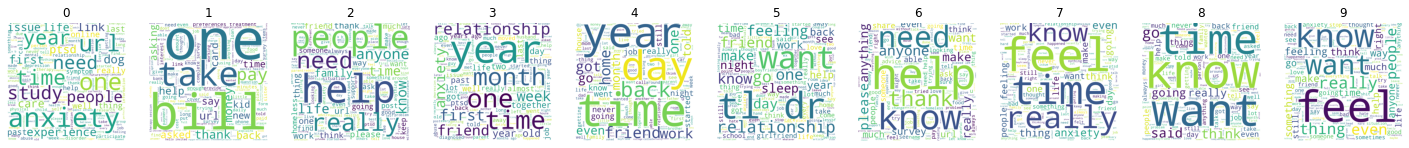

In [26]:
# First way to find the clusters' topic. ---> Creating word cloud for each cluster

from wordcloud import WordCloud
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,10, figsize = (25,10))
for i in range(len(text_by_clusters)):
    wordcloud = WordCloud(background_color = 'white',
                              width = 1200,
                              height = 1200).generate(text_by_clusters[i][0]) 
    ax[i].imshow(wordcloud)
    ax[i].grid(False)
    ax[i].axis('off')
    ax[i].title.set_text(str(text_by_clusters[i][1]))

In [27]:
import pandas as pd
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [28]:
# Second way to find the clusters' topic. ---> Finding most common 20 words and print them based on their cluster
# The purpose of this function is finding the clusters' topic based of top  common words.
# The key words has been found from these 20 words
def find_cluster_word2vec(text_by_clusters):
    topic = [[],[],[]]
#Index(['ptsd', 'relationships', 'anxiety', 'domesticviolence', 'assistance', 'survivorsofabuse', 'homeless', 'almosthomeless', 'stress', 'food_pantry'],dtype='object')
   
    ptsd = 0
    relationships = 0
    anxiety =0
    domesticviolence = 0
    assistance = 0
    survivorsofabuse =0
    homeless =0 
    almosthomeless = 0
    stress =0 
    food_pantry = 0


    array = []
    for i, text in enumerate(text_by_clusters):
        tokenized_words = nltk.tokenize.word_tokenize(text[0])
        word_dist = FreqDist(tokenized_words)
        for word, frequency in word_dist.most_common(5000):
            topic[0].append(int(text[1]))
            topic[1].append(word)
            topic[2].append(frequency)

    topic = np.array(topic).T
    topic= pd.DataFrame(topic)
    topic[0] = topic[0].astype(int)

    print(len(np.unique(topic.iloc[:,0])))

    for i in range(len(np.unique(topic.iloc[:,0]))):
        common_words = topic[topic.iloc[:,0] == i].iloc[:,1]
        print(f'Cluster {i}: most common words are {[common_words.iloc[a] for a in range(len(common_words))]}')
        if np.isin(np.array(common_words[:]), ['ptsd', 'trauma','shock','feel', 'like', 'know']).sum() > 0:
            ptsd =i
        if np.isin(np.array(common_words[:]), ['relation','really', 'need', 'feel', 'people','relationship']).sum() > 0:
            relationships =i
        if np.isin(np.array(common_words[:]), ['anxiety','things', 'people', 'much', 'still', 'something', 'make', 'never']).sum() > 0:
            anxiety =i
        if np.isin(np.array(common_words[:]), ['domesticviolence','really', 'feel', 'boyfriend', 'time', 'work', 'something', 'one', 'anything']).sum() > 0:
            relationships =i
        if np.isin(np.array(common_words[:]), ['assistance','friends', 'get', 'told', 'last', 'going', 'never', 'even', 'know', 'think', 'started', 'months']).sum() > 0:
            assistance =i
        if np.isin(np.array(common_words[:]), ['survivorsofabuse','crime','life', 'people', 'moved', 'go', 'get', 'could',]).sum() > 0:
           survivorsofabuse = i
        if np.isin(np.array(common_words[:]), ['homeless', 'home','together', 'past', 'started', 'even', 'went', 'well', 'back', 'really', 'weeks', 'long', 'day']).sum() > 0:
            homeless =i
        if np.isin(np.array(common_words[:]), ['almosthomeless','away', 'said', 'getting', 'every', 'parents', 'take', 'family', 'sleep']).sum() > 0:
            almosthomeless =i
        if np.isin(np.array(common_words[:]), ['stress','friend', 'going', 'times', 'dr', 'really', 'years', 'feeling', 'still', 'one', 'money', 'best']).sum() > 0:
            stress =i
        if np.isin(np.array(common_words[:]), ['food_pantry','health', 'preferences', 'could', 'link', 'information']).sum() > 0:
            food_pantry = i


    return {
        'ptsd': [ptsd], 
        'relationships' : [relationships],
        'anxiety': [anxiety], 
        'relationships': [relationships], 
        'domesticviolence': [domesticviolence],
        'assistance': [assistance],
        'survivorsofabuse': [survivorsofabuse],
        'homeless': [homeless],
        'almosthomeless': [almosthomeless],
        'stress': [stress],
        'food_pantry': [food_pantry],
    }

print('\n--------Without Cleaning CLuster Predictions--------\n')
predicted_classes = pd.DataFrame(find_cluster_word2vec(text_by_clusters),index = ['cluster_numbers'])
print('\n--------predicated classes--------\n')
print(predicted_classes)


--------Without Cleaning CLuster Predictions--------

10
Cluster 0: most common words are ['anxiety', 'url', 'one', 'study', 'need', 'time', 'also', 'years', 'care', 'people', 'first', 'participate', 'ptsd', 'life', 'link', 'really', 'experience', 'well', 'last', 'support', 'past', 'like', 'online', 'symptoms', 'self', 'never', 'person', 'issues', 'please', 'call', 'things', 'depression', 'panic', 'times', 'long', 'due', 'abuse', 'something', 'therapy', 'disorder', 'thank', 'child', 'b', 'think', 'physical', 'find', 'made', 'believe', 'would', 'may', 'etc', 'dogs', 'good', 'information', 'year', 'yet', 'us', 'research', 'mental', 'x', 'getting', 'many', 'less', 'ever', 'started', 'relationship', 'today', 'take', 'helps', 'around', 'nothing', 'group', 'important', 'lot', 'health', 'future', 'current', 'experienced', 'k', 'enough', 'work', 'got', 'together', 'therapist', 'old', 'currently', 'still', 'always', 'break', 'every', 'said', 'attack', 'minutes', 'obviously', 'live', 'sure', 'a

In [32]:
def confusion_matrix(results, predicted_classes):
    temp_array = np.zeros((10,10), dtype = int)
    cm = pd.DataFrame(temp_array, index = predicted_classes.keys(), columns = predicted_classes.keys())

    for i in range(len(results)):
        cm.loc[results[i][2], predicted_classes.T[predicted_classes.T == results[i][1]].dropna().index.values[0]] +=1
    return cm

In [30]:
print("****************results*****************")
print(results)
print("*********Predicatd classes****************")
print(predicted_classes)
print(predicted_classes.keys())

****************results*****************
[[list(['hello', 'invited', 'complete', 'survey', 'wmu', 'psychology', 'department', 'research', 'project', 'designed', 'assess', 'treatment', 'preferences', 'among', 'adults', 'seeking', 'treatment', 'variety', 'concerns', 'hope', 'learn', 'preferences', 'treatment', 'change', 'time', 'patient', 'perception', 'treatment', 'match', 'preferences', 'related', 'benefit', 'received', 'treatment', 'survey', 'open', 'anyone', 'ages', 'older', 'currently', 'engaged', 'mental', 'health', 'treatment', 'least', 'one', 'month', 'four', 'therapy', 'sessions', 'longer', 'one', 'year', 'choose', 'participate', 'asked', 'provide', 'demographic', 'background', 'information', 'respond', 'survey', 'items', 'preferences', 'treatment', 'changed', 'time', 'quality', 'life', 'survey', 'may', 'take', 'minutes', 'complete'])
  1 'stress']
 [list(['want', 'know', 'story', 'got', 'struggles', 'never', 'realized', 'would', 'face', 'well', 'dealt', 'ones', 'already', 'expe